# Dataset Creation

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import warnings
#normalização de sentenças
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
#analise de sentimentos
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [31]:
nltk.download("punkt")
warnings.filterwarnings("ignore")
columns = ['target','text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv',usecols=columns,encoding="ISO-8859-1") #necessitamos apenas do tweet e o message type(negative, positive, neutral
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [33]:
def sentiment(frase):
  sent = SentimentIntensityAnalyzer()
  return sent.polarity_scores(frase)
teste = 'i want to suicide'
print('i want to suicide',sentiment(teste)['neg'])
teste = 'i hate storms'
print('i hate storms',sentiment(teste)['neg'])

i want to suicide 0.577
i hate storms 0.649


In [35]:
#negativos
neg = df.loc[df['target'] == 0]

#função que define wordcloud a partir de uma palavra
def wcloud(word):
  withdep = []
  for i in neg.index:
    j = neg.loc[i]['text']
    if word in j:
      vaderPerc = sentiment(j) 
      if vaderPerc['neg']>=0.4 : 
        withdep.append(j)
        neg.drop(i)
  if len(withdep)>0:
    text = " ".join(i for i in withdep)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
  return len(withdep)

neg.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [36]:
lancaster = LancasterStemmer()
def stemSentence(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [37]:
words = ['depression','feeling','lonely','suicide','killing myself']
for i in range(len(words)):
    words[i] = lancaster.stem(words[i])
#ATRIBUINDO VADER COMO COLUNA
withwords = pd.DataFrame()
string = '|'.join(words)
withwords = neg.loc[neg['text'].str.contains(string)]
#dessas que contem palavras, criar vaderscore
vader = [sentiment(i)['neg'] for i in withwords['text']]
withwords['vader'] = vader
withwords.head()

,target,text,vader
3,0,my whole body feels itchy and like its on fire,0.321
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,0.149
29,0,Meh... Almost Lover is the exception... this t...,0.254
38,0,@fleurylis I don't either. Its depressing. I d...,0.000
40,0,really don't feel like getting up today... but...,0.101


In [ ]:
for i in words:
    wcloud(i)

In [38]:
depressive = []
for i in withwords.index:
    if withwords['vader'][i] > 0.4:
        depressive.append(withwords['text'][i])
target = [1 for i in depressive]
#dp: dataframe with all depressive tweets
dp = pd.DataFrame()
dp['target'] = target
dp['text'] = depressive
#nondepressive
nondp = df.loc[df['target'] != 0]
nondp['target'] = 0

Assim foi verificado 19621 instancias que podemos classificar como depressivas, com isso:

- Colocar instancias de depressão como 1, e não depressivas como 0;
- Sortear instancias para treino e validação numa proporção de 10% depressivas(aproximadamente 18000), 90% não depressivas(aproximadamente 180000)


Criando Dataset de Depressão

In [39]:
#embaralhando e escolhendo aleatoriamente
dp = dp.sample(frac=1)
nondp = nondp.sample(180000)
dout = nondp.append(dp, ignore_index=True)
dout = dout.sample(frac=1)
dout.to_csv("out.csv")

# Making Neural Network

In [40]:
import pandas as pd
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Dense, Dropout, Embedding, MaxPooling1D, LSTM
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import tensorflow as tf

import numpy as np
from gensim.models import KeyedVectors

PreProcessing

In [41]:
df = pd.read_csv('out.csv',usecols=['target','text'] ,encoding="ISO-8859-1")
X_train, X_test, y_train, y_test = train_test_split(
     df["text"], df["target"], test_size=0.2, random_state=42)
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [42]:
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [43]:
word_index = tokenizer.word_index
data_train = pad_sequences(sequences_train, maxlen=280)
data_test = pad_sequences(sequences_test, maxlen=280)

In [44]:
nb_words = min(25000, len(word_index))
embedding_matrix = np.zeros((nb_words, 300))
for (word, idx) in word_index.items():
    if word in word2vec.key_to_index and idx < 25000:
        embedding_matrix[idx] = word2vec.word_vec(word)

Verifying GPU Device for faster Training (In this case to use tensorflow_gpu)

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training

In [46]:

model = Sequential()
model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                            input_length=280, trainable=False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.5))
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['acc'])
early_stop = EarlyStopping(monitor='val_loss', patience=3)
hist = model.fit(data_train, y_train,
                validation_data=(data_test, y_test),
                epochs=5, batch_size=16, shuffle=True,
                callbacks=[early_stop])

Epoch 1/5
9285/9285 [==============================] - 137s 15ms/step - loss: 0.0363 - acc: 0.9885 - val_loss: 0.0170 - val_acc: 0.9943
Epoch 2/5
9285/9285 [==============================] - 144s 15ms/step - loss: 0.0180 - acc: 0.9939 - val_loss: 0.0149 - val_acc: 0.9948
Epoch 3/5
9285/9285 [==============================] - 137s 15ms/step - loss: 0.0148 - acc: 0.9951 - val_loss: 0.0120 - val_acc: 0.9962
Epoch 4/5
9285/9285 [==============================] - 136s 15ms/step - loss: 0.0130 - acc: 0.9956 - val_loss: 0.0126 - val_acc: 0.9959
Epoch 5/5
9285/9285 [==============================] - 132s 14ms/step - loss: 0.0121 - acc: 0.9959 - val_loss: 0.0111 - val_acc: 0.9967


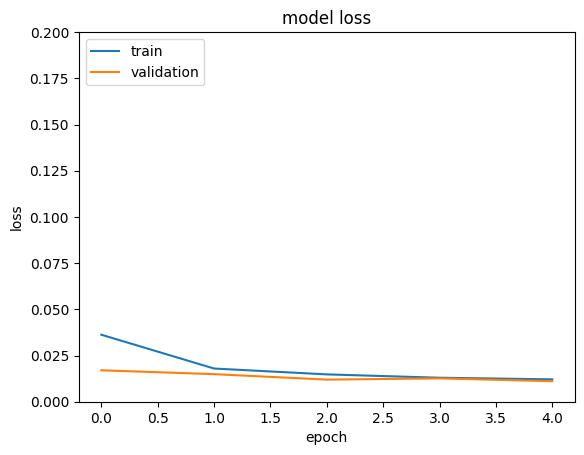

In [47]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Testing with Reddit Dataset

In [48]:
columns = ['target','text']
df = pd.read_csv('depression_dataset_reddit_cleaned.csv',usecols=columns,encoding="ISO-8859-1") #necessitamos apenas do tweet e o message type(negative, positive, neutral
df.head()
sequences_reddit = tokenizer.texts_to_sequences(df["text"])
data_reddit = pad_sequences(sequences_reddit, maxlen=280)
ypred = model.predict(data_reddit)
ypred = np.round(ypred).astype("int")
balanced_acc = balanced_accuracy_score(df["target"], ypred)

acc = accuracy_score(df["target"], ypred)
print(balanced_acc)
print(acc)

242/242 [==============================] - 2s 6ms/step
0.5477253378310544
0.5514163756305782
